### The 2d Darcy's Flow 
The Darcy's problem is given as:
\begin{equation}
\begin{cases}
- \nabla(\cdot a(x) \nabla u(x)) &= f(x), \quad x\in\Omega\\
       u  &=0, \quad x\in\partial\Omega
\end{cases}
\end{equation}
where $\Omega=[0,1]^2$. We consider the coefficient $a(x)$ with the following form:
\begin{equation}
a(x) = 2.1 + \sin(\beta_1 x_1) + \cos(\beta_2  x_2)
\end{equation}
where $\beta_1=5.0011, \beta_2=3.3723$.

### (1) Prepare the data

<KeysViewHDF5 ['X', 'Y', 'beta1', 'beta2', 'coeff', 'sol', 'soldx', 'soldy']>


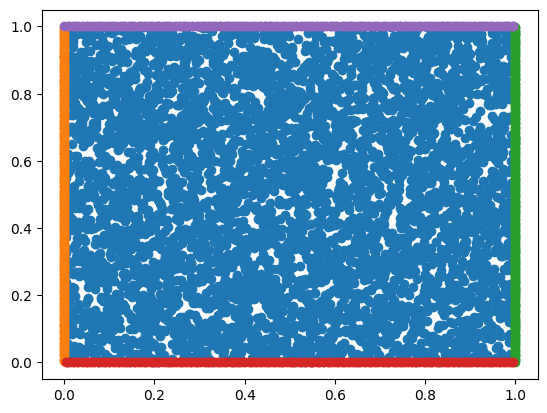

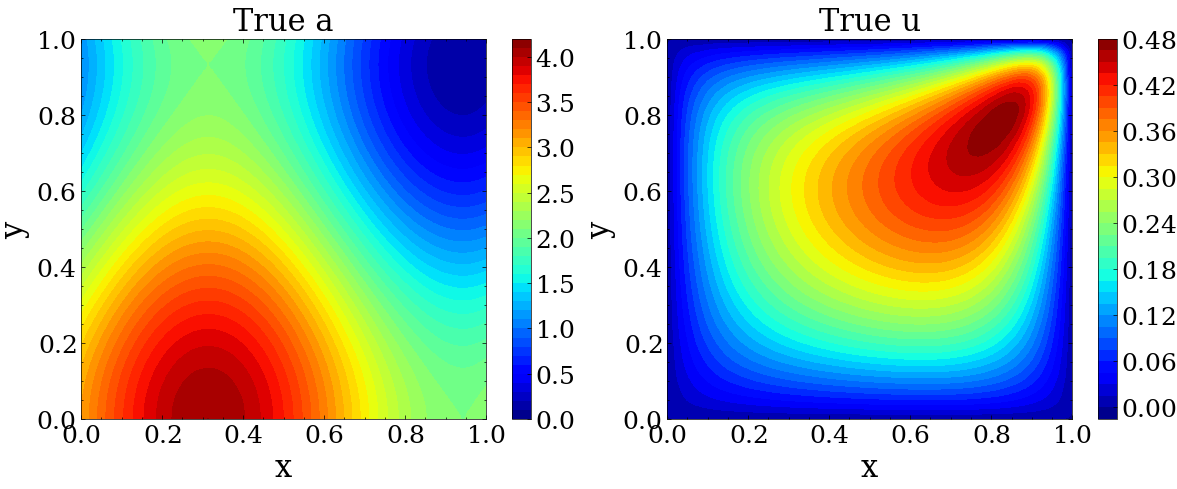

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
random_seed = 123
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
######################################
# Load reference data
######################################
from Utils.utils import *
data_test = h5py.File('../../Problems/Darcy_Flow/truth_cts_2d.mat', 'r')
print(data_test.keys())
#
def get_data(data, inx, dtype):
    a = np.array(data["coeff"][...,inx]).T
    u = np.array(data["sol"][...,inx]).T
    ux = np.array(data["soldx"][...,inx]).T
    uy = np.array(data["soldy"][...,inx]).T
    beta1 = np.array(data["beta1"][inx])
    beta2 = np.array(data["beta2"][inx])
    #
    X, Y = np.array(data['X']).T, np.array(data['Y']).T
    mesh = np.vstack([X.ravel(), Y.ravel()]).T
    #
    a = a.reshape(-1, 1)
    u = u.reshape(-1, 1)
    ux = ux.reshape(-1, 1)
    uy = uy.reshape(-1, 1)
    
    return np2tensor(a, dtype), np2tensor(u, dtype), np2tensor(mesh, dtype), \
            np2tensor(ux, dtype), np2tensor(uy, dtype), np2tensor(beta1, dtype), np2tensor(beta2, dtype)
#
a_test, u_test, x_test, ux_test, uy_test, beta1, beta2 = get_data(data_test, 0, dtype)
######################################
# Generate training data
######################################
from Utils.GenPoints import Point2D
pointGen = Point2D(x_lb=[0., 0.], x_ub=[1.,1.], dataType=dtype, random_seed=random_seed)
#
N_center, N_bd_each_edge = 5000, 200
xc, R = pointGen.weight_centers(n_center=N_center, R_max=1e-4, R_min=1e-4)
x_bd_train = pointGen.boundary_point(num_each_edge=N_bd_each_edge, method='hypercube')
#
x_lt = x_bd_train[0:N_bd_each_edge]
x_rt = x_bd_train[N_bd_each_edge:2*N_bd_each_edge]
x_bt = x_bd_train[2*N_bd_each_edge:3*N_bd_each_edge]
x_up = x_bd_train[3*N_bd_each_edge:]
#########################################
plt.figure()
plt.scatter(xc[...,0], xc[...,1])
plt.scatter(x_lt[:,0], x_lt[:,1])
plt.scatter(x_rt[:,0], x_rt[:,1])
plt.scatter(x_bt[:,0], x_bt[:,1])
plt.scatter(x_up[:,0], x_up[:,1])
plt.show()
#######################################
from Utils.PlotFigure import Plot
Plot.show_2d_list(x_test, [a_test, u_test], ['True a', 'True u'])

### (2) Define the loss class

In [2]:
from torch.autograd import grad, Variable
from Utils.GenPoints import Point2D
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN
###############################
# The test function
###############################
int_grid, phi, dphi_dr = TestFun_ParticleWNN(
    fun_type='Wendland', dim=2, n_mesh_or_grid=15, 
    dataType=dtype).get_testFun()

###############################
# The coefficient function
###############################
class Fun_a(object):

    def __init__(self, betax, betay):
        self.betax = betax
        self.betay = betay
        
    def __call__(self, x):
        '''
        '''
        a = 2.1 + torch.sin(self.betax * x[...,0:1]) + torch.cos(self.betay * x[...,1:2])
        return a

######################################
## The mollifier (to satisfy the boundary condition)
######################################
class mollifer(object):

    def __inint__(self):
        super(mollifer, self).__init_()
        
    def __call__(self, u, grid):
        '''Define the mollifer
        '''
        x_mesh, y_mesh = grid[...,0:1], grid[...,1:2]
        u = u * torch.sin(np.pi * x_mesh)*torch.sin(np.pi * y_mesh)
        return u
    
##################################
##### The loss Class
##################################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        '''
        '''
        self.solver = solver
        self.mollifer = mollifer()
        self.dtype = solver.dtype
        self.device = solver.device
        self.model_a = Fun_a(beta1[0].to(self.device), beta2[0].to(self.device))
        self.model_u = solver.model_dict['u']
        ######################## 
        self.int_grid = int_grid.to(self.solver.device)
        self.n_grid = int_grid.shape[0]
        self.v = phi.to(self.solver.device)
        self.dv_dr = dphi_dr.to(self.solver.device)
        
    def Loss_pde(self, xc=None, R=None):
        '''Define the PDE loss
        '''
        ################################## The collocation points
        nc = xc.shape[0]
        x = self.int_grid * R + xc
        x = Variable(x.reshape(-1, 2), requires_grad=True)
        ##########################################
        v = self.v.repeat((nc,1,1)).reshape(-1,1)
        dv = (self.dv_dr / R).reshape(-1, 2)
        ##########################################
        a = self.model_a(x)
        u = self.model_u(x)
        if self.mollifer is not None:
            u = self.mollifer(u, x)
        du = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        f = 10. * torch.ones_like(u)
        ###########################################
        right = torch.sum( a * (du * dv), dim=-1).reshape(nc, self.n_grid)
        right = torch.mean(right, dim=-1)
        left = (f * v).reshape(nc, self.n_grid)
        left = torch.mean(left, dim=-1)
        ###########################################
        loss = self.solver.getLoss(left, right)
        
        return loss * np.sqrt(nc)

    def Loss_bd(self):
        ''' '''
        loss = torch.tensor(0., device=self.solver.device)
        
        return loss * 1.
        
    def Error(self):
        '''
        '''
        x = x_test.to(self.solver.device)
        u = u_test.to(self.solver.device)
        ####### 
        u_pred = self.model_u(x)
        if self.mollifer is not None:
            u_pred = self.mollifer(u_pred, x)
        #
        error = self.solver.getError(u_pred, u)

        return error

##########################################
from Solvers.ParticleWNN import ParticleWNN
#
solver = ParticleWNN.Solver(device, dtype=dtype)
model_u = solver.getModel([2, 40, 40, 40, 1], 'Tanh', netType='FCNet')

### (3) training and prediction

#### (3.1) Train the model

In [3]:
model_dict = {'u':model_u}
solver.train_setup(model_dict, lr=1e-3, optimizer='Adam', scheduler_type='StepLR', lbfgs=False, max_iter=1000)
solver.train(LossClass, xc, R, batch_size_in=50, epochs=1000, **{'save_path':'saved_models/cts/'})
# solver.train_lbfgs(LossClass, xc, R, epochs=200, **{'save_path':'saved_models/cts/'})

  1%|▌                                                       | 10/1000 [00:05<08:22,  1.97it/s]

Epoch:10 Time:5.5286, loss_in:28.018438, loss_bd:0.000000
    l2_err:0.24591794610023499, 
    lr:[0.001]


  2%|█                                                       | 20/1000 [00:10<07:58,  2.05it/s]

Epoch:20 Time:10.4009, loss_in:22.479321, loss_bd:0.000000
    l2_err:0.17216984927654266, 
    lr:[0.001]


  3%|█▋                                                      | 30/1000 [00:15<07:59,  2.02it/s]

Epoch:30 Time:15.3307, loss_in:22.503723, loss_bd:0.000000
    l2_err:0.18990842998027802, 
    lr:[0.001]


  4%|██▏                                                     | 40/1000 [00:20<07:43,  2.07it/s]

Epoch:40 Time:20.1875, loss_in:21.076471, loss_bd:0.000000
    l2_err:0.1270264834165573, 
    lr:[0.001]


  5%|██▊                                                     | 50/1000 [00:24<07:36,  2.08it/s]

Epoch:50 Time:24.9977, loss_in:15.205419, loss_bd:0.000000
    l2_err:0.11433930695056915, 
    lr:[0.001]


  6%|███▎                                                    | 60/1000 [00:29<07:31,  2.08it/s]

Epoch:60 Time:29.8015, loss_in:12.763836, loss_bd:0.000000
    l2_err:0.08600673824548721, 
    lr:[0.001]


  7%|███▉                                                    | 70/1000 [00:34<07:29,  2.07it/s]

Epoch:70 Time:34.6259, loss_in:12.837482, loss_bd:0.000000
    l2_err:0.0977255180478096, 
    lr:[0.001]


  8%|████▍                                                   | 80/1000 [00:39<07:24,  2.07it/s]

Epoch:80 Time:39.4735, loss_in:10.966912, loss_bd:0.000000
    l2_err:0.0604458786547184, 
    lr:[0.001]


  9%|█████                                                   | 90/1000 [00:44<07:18,  2.08it/s]

Epoch:90 Time:44.3010, loss_in:9.926380, loss_bd:0.000000
    l2_err:0.055176444351673126, 
    lr:[0.001]


 10%|█████▌                                                 | 100/1000 [00:49<07:10,  2.09it/s]

Epoch:100 Time:49.0857, loss_in:9.588599, loss_bd:0.000000
    l2_err:0.052051398903131485, 
    lr:[0.001]


 11%|██████                                                 | 110/1000 [00:53<07:05,  2.09it/s]

Epoch:110 Time:53.8711, loss_in:8.440151, loss_bd:0.000000
    l2_err:0.04037187248468399, 
    lr:[0.001]


 12%|██████▌                                                | 120/1000 [00:58<07:03,  2.08it/s]

Epoch:120 Time:58.6574, loss_in:8.086017, loss_bd:0.000000
    l2_err:0.04936136305332184, 
    lr:[0.001]


 13%|███████▏                                               | 130/1000 [01:03<06:51,  2.12it/s]

Epoch:130 Time:63.4332, loss_in:7.600141, loss_bd:0.000000
    l2_err:0.0348532609641552, 
    lr:[0.001]


 14%|███████▋                                               | 140/1000 [01:06<04:14,  3.37it/s]

Epoch:140 Time:66.3571, loss_in:7.207346, loss_bd:0.000000
    l2_err:0.034703031182289124, 
    lr:[0.001]


 15%|████████▎                                              | 150/1000 [01:09<04:08,  3.42it/s]

Epoch:150 Time:69.2850, loss_in:6.450571, loss_bd:0.000000
    l2_err:0.022101348266005516, 
    lr:[0.001]


 16%|████████▊                                              | 160/1000 [01:12<04:06,  3.40it/s]

Epoch:160 Time:72.2324, loss_in:5.746871, loss_bd:0.000000
    l2_err:0.021564694121479988, 
    lr:[0.001]


 17%|█████████▎                                             | 170/1000 [01:15<04:12,  3.29it/s]

Epoch:170 Time:75.2280, loss_in:6.431533, loss_bd:0.000000
    l2_err:0.021321358159184456, 
    lr:[0.001]


 18%|█████████▉                                             | 180/1000 [01:18<04:02,  3.38it/s]

Epoch:180 Time:78.2009, loss_in:5.811351, loss_bd:0.000000
    l2_err:0.030047819018363953, 
    lr:[0.001]


 19%|██████████▍                                            | 190/1000 [01:21<04:05,  3.30it/s]

Epoch:190 Time:81.1712, loss_in:5.652308, loss_bd:0.000000
    l2_err:0.02728351391851902, 
    lr:[0.001]


 20%|███████████                                            | 200/1000 [01:24<03:54,  3.41it/s]

Epoch:200 Time:84.1450, loss_in:4.750969, loss_bd:0.000000
    l2_err:0.018642306327819824, 
    lr:[0.0005]


 21%|███████████▌                                           | 210/1000 [01:27<03:53,  3.39it/s]

Epoch:210 Time:87.0807, loss_in:4.907290, loss_bd:0.000000
    l2_err:0.029154887422919273, 
    lr:[0.0005]


 22%|████████████                                           | 220/1000 [01:30<03:49,  3.40it/s]

Epoch:220 Time:90.0295, loss_in:4.146952, loss_bd:0.000000
    l2_err:0.015734432265162468, 
    lr:[0.0005]


 23%|████████████▋                                          | 230/1000 [01:32<03:46,  3.40it/s]

Epoch:230 Time:92.9667, loss_in:4.080818, loss_bd:0.000000
    l2_err:0.01578974723815918, 
    lr:[0.0005]


 24%|█████████████▏                                         | 240/1000 [01:35<03:44,  3.39it/s]

Epoch:240 Time:95.9133, loss_in:4.157969, loss_bd:0.000000
    l2_err:0.007926086895167828, 
    lr:[0.0005]


 25%|█████████████▊                                         | 250/1000 [01:38<03:44,  3.34it/s]

Epoch:250 Time:98.8543, loss_in:3.864567, loss_bd:0.000000
    l2_err:0.012520424090325832, 
    lr:[0.0005]


 26%|██████████████▎                                        | 260/1000 [01:41<03:48,  3.25it/s]

Epoch:260 Time:101.9390, loss_in:3.810777, loss_bd:0.000000
    l2_err:0.020240573212504387, 
    lr:[0.0005]


 27%|██████████████▊                                        | 270/1000 [01:45<03:45,  3.24it/s]

Epoch:270 Time:105.0297, loss_in:3.643785, loss_bd:0.000000
    l2_err:0.004304553382098675, 
    lr:[0.0005]


 28%|███████████████▍                                       | 280/1000 [01:48<03:41,  3.24it/s]

Epoch:280 Time:108.1126, loss_in:3.611524, loss_bd:0.000000
    l2_err:0.003991612698882818, 
    lr:[0.0005]


 29%|███████████████▉                                       | 290/1000 [01:51<03:38,  3.24it/s]

Epoch:290 Time:111.1926, loss_in:3.615083, loss_bd:0.000000
    l2_err:0.0121616767719388, 
    lr:[0.0005]


 30%|████████████████▌                                      | 300/1000 [01:54<03:36,  3.24it/s]

Epoch:300 Time:114.2775, loss_in:3.500545, loss_bd:0.000000
    l2_err:0.008237602189183235, 
    lr:[0.0005]


 31%|█████████████████                                      | 310/1000 [01:57<03:32,  3.24it/s]

Epoch:310 Time:117.3671, loss_in:3.425398, loss_bd:0.000000
    l2_err:0.004585830494761467, 
    lr:[0.0005]


 32%|█████████████████▌                                     | 320/1000 [02:00<03:29,  3.25it/s]

Epoch:320 Time:120.4450, loss_in:3.632371, loss_bd:0.000000
    l2_err:0.008884663693606853, 
    lr:[0.0005]


 33%|██████████████████▏                                    | 330/1000 [02:03<03:26,  3.25it/s]

Epoch:330 Time:123.5252, loss_in:3.495995, loss_bd:0.000000
    l2_err:0.016069186851382256, 
    lr:[0.0005]


 34%|██████████████████▋                                    | 340/1000 [02:06<03:23,  3.24it/s]

Epoch:340 Time:126.6108, loss_in:3.341653, loss_bd:0.000000
    l2_err:0.005997487809509039, 
    lr:[0.0005]


 35%|███████████████████▎                                   | 350/1000 [02:09<03:19,  3.25it/s]

Epoch:350 Time:129.6848, loss_in:3.397201, loss_bd:0.000000
    l2_err:0.005883830599486828, 
    lr:[0.0005]


 36%|███████████████████▊                                   | 360/1000 [02:12<03:17,  3.24it/s]

Epoch:360 Time:132.7674, loss_in:3.287093, loss_bd:0.000000
    l2_err:0.014965379610657692, 
    lr:[0.0005]


 37%|████████████████████▎                                  | 370/1000 [02:15<03:14,  3.25it/s]

Epoch:370 Time:135.8464, loss_in:3.240357, loss_bd:0.000000
    l2_err:0.0034223534166812897, 
    lr:[0.0005]


 38%|████████████████████▉                                  | 380/1000 [02:18<03:10,  3.25it/s]

Epoch:380 Time:138.9260, loss_in:3.133472, loss_bd:0.000000
    l2_err:0.010493929497897625, 
    lr:[0.0005]


 39%|█████████████████████▍                                 | 390/1000 [02:22<03:08,  3.24it/s]

Epoch:390 Time:142.0120, loss_in:3.080671, loss_bd:0.000000
    l2_err:0.00720521155744791, 
    lr:[0.0005]


 40%|██████████████████████                                 | 400/1000 [02:25<03:04,  3.24it/s]

Epoch:400 Time:145.0940, loss_in:3.323373, loss_bd:0.000000
    l2_err:0.010013706982135773, 
    lr:[0.00025]


 41%|██████████████████████▌                                | 410/1000 [02:28<03:02,  3.24it/s]

Epoch:410 Time:148.1798, loss_in:3.043582, loss_bd:0.000000
    l2_err:0.004940572660416365, 
    lr:[0.00025]


 42%|███████████████████████                                | 420/1000 [02:31<02:58,  3.24it/s]

Epoch:420 Time:151.2595, loss_in:3.030771, loss_bd:0.000000
    l2_err:0.003837538417428732, 
    lr:[0.00025]


 43%|███████████████████████▋                               | 430/1000 [02:34<02:55,  3.25it/s]

Epoch:430 Time:154.3424, loss_in:2.928351, loss_bd:0.000000
    l2_err:0.0065602767281234264, 
    lr:[0.00025]


 44%|████████████████████████▏                              | 440/1000 [02:37<02:52,  3.25it/s]

Epoch:440 Time:157.4173, loss_in:2.919443, loss_bd:0.000000
    l2_err:0.0031272165942937136, 
    lr:[0.00025]


 45%|████████████████████████▊                              | 450/1000 [02:40<02:49,  3.24it/s]

Epoch:450 Time:160.4992, loss_in:2.893440, loss_bd:0.000000
    l2_err:0.0028519360348582268, 
    lr:[0.00025]


 46%|█████████████████████████▎                             | 460/1000 [02:43<02:46,  3.25it/s]

Epoch:460 Time:163.5792, loss_in:2.893433, loss_bd:0.000000
    l2_err:0.002589637180790305, 
    lr:[0.00025]


 47%|█████████████████████████▊                             | 470/1000 [02:46<02:43,  3.24it/s]

Epoch:470 Time:166.6629, loss_in:2.871793, loss_bd:0.000000
    l2_err:0.003094871062785387, 
    lr:[0.00025]


 48%|██████████████████████████▍                            | 480/1000 [02:49<02:40,  3.24it/s]

Epoch:480 Time:169.7508, loss_in:2.987708, loss_bd:0.000000
    l2_err:0.003138663712888956, 
    lr:[0.00025]


 49%|██████████████████████████▉                            | 490/1000 [02:52<02:37,  3.24it/s]

Epoch:490 Time:172.8358, loss_in:2.867043, loss_bd:0.000000
    l2_err:0.006226265337318182, 
    lr:[0.00025]


 50%|███████████████████████████▌                           | 500/1000 [02:55<02:34,  3.23it/s]

Epoch:500 Time:175.9215, loss_in:2.802023, loss_bd:0.000000
    l2_err:0.0023379079066216946, 
    lr:[0.00025]


 51%|████████████████████████████                           | 510/1000 [02:59<02:31,  3.24it/s]

Epoch:510 Time:179.0074, loss_in:2.808423, loss_bd:0.000000
    l2_err:0.006720659323036671, 
    lr:[0.00025]


 52%|████████████████████████████▌                          | 520/1000 [03:02<02:28,  3.24it/s]

Epoch:520 Time:182.0882, loss_in:2.827041, loss_bd:0.000000
    l2_err:0.004128106404095888, 
    lr:[0.00025]


 53%|█████████████████████████████▏                         | 530/1000 [03:05<02:25,  3.23it/s]

Epoch:530 Time:185.1941, loss_in:2.776477, loss_bd:0.000000
    l2_err:0.002190029015764594, 
    lr:[0.00025]


 54%|█████████████████████████████▋                         | 540/1000 [03:08<02:15,  3.40it/s]

Epoch:540 Time:188.1994, loss_in:2.891005, loss_bd:0.000000
    l2_err:0.006058857776224613, 
    lr:[0.00025]


 55%|██████████████████████████████▎                        | 550/1000 [03:11<02:11,  3.42it/s]

Epoch:550 Time:191.1224, loss_in:2.821964, loss_bd:0.000000
    l2_err:0.002113831927999854, 
    lr:[0.00025]


 56%|██████████████████████████████▊                        | 560/1000 [03:14<02:08,  3.43it/s]

Epoch:560 Time:194.0378, loss_in:2.716683, loss_bd:0.000000
    l2_err:0.006454651243984699, 
    lr:[0.00025]


 57%|███████████████████████████████▎                       | 570/1000 [03:16<02:05,  3.44it/s]

Epoch:570 Time:196.9527, loss_in:2.713465, loss_bd:0.000000
    l2_err:0.0028067980892956257, 
    lr:[0.00025]


 58%|███████████████████████████████▉                       | 580/1000 [03:19<02:02,  3.44it/s]

Epoch:580 Time:199.8538, loss_in:2.683519, loss_bd:0.000000
    l2_err:0.0021104293409734964, 
    lr:[0.00025]


 59%|████████████████████████████████▍                      | 590/1000 [03:22<01:59,  3.43it/s]

Epoch:590 Time:202.7695, loss_in:2.663548, loss_bd:0.000000
    l2_err:0.005071097519248724, 
    lr:[0.00025]


 60%|█████████████████████████████████                      | 600/1000 [03:25<01:56,  3.44it/s]

Epoch:600 Time:205.6767, loss_in:2.718870, loss_bd:0.000000
    l2_err:0.0029914325568825006, 
    lr:[0.000125]


 61%|█████████████████████████████████▌                     | 610/1000 [03:28<01:54,  3.42it/s]

Epoch:610 Time:208.5994, loss_in:2.622028, loss_bd:0.000000
    l2_err:0.0033780604135245085, 
    lr:[0.000125]


 62%|██████████████████████████████████                     | 620/1000 [03:31<01:50,  3.44it/s]

Epoch:620 Time:211.5236, loss_in:2.629944, loss_bd:0.000000
    l2_err:0.001637688372284174, 
    lr:[0.000125]


 63%|██████████████████████████████████▋                    | 630/1000 [03:34<01:47,  3.44it/s]

Epoch:630 Time:214.4269, loss_in:2.616838, loss_bd:0.000000
    l2_err:0.0016835418064147234, 
    lr:[0.000125]


 64%|███████████████████████████████████▏                   | 640/1000 [03:37<01:44,  3.45it/s]

Epoch:640 Time:217.3357, loss_in:2.639560, loss_bd:0.000000
    l2_err:0.002298706443980336, 
    lr:[0.000125]


 65%|███████████████████████████████████▊                   | 650/1000 [03:40<01:41,  3.43it/s]

Epoch:650 Time:220.2475, loss_in:2.585234, loss_bd:0.000000
    l2_err:0.0020095445215702057, 
    lr:[0.000125]


 66%|████████████████████████████████████▎                  | 660/1000 [03:43<01:38,  3.45it/s]

Epoch:660 Time:223.1561, loss_in:2.568206, loss_bd:0.000000
    l2_err:0.0019279149128124118, 
    lr:[0.000125]


 67%|████████████████████████████████████▊                  | 670/1000 [03:46<01:36,  3.43it/s]

Epoch:670 Time:226.0713, loss_in:2.576998, loss_bd:0.000000
    l2_err:0.0013223126297816634, 
    lr:[0.000125]


 68%|█████████████████████████████████████▍                 | 680/1000 [03:48<01:33,  3.42it/s]

Epoch:680 Time:228.9950, loss_in:2.561011, loss_bd:0.000000
    l2_err:0.001905982382595539, 
    lr:[0.000125]


 69%|█████████████████████████████████████▉                 | 690/1000 [03:51<01:30,  3.43it/s]

Epoch:690 Time:231.9077, loss_in:2.556639, loss_bd:0.000000
    l2_err:0.0014519599499180913, 
    lr:[0.000125]


 70%|██████████████████████████████████████▌                | 700/1000 [03:54<01:27,  3.42it/s]

Epoch:700 Time:234.8173, loss_in:2.562724, loss_bd:0.000000
    l2_err:0.002864845795556903, 
    lr:[0.000125]


 71%|███████████████████████████████████████                | 710/1000 [03:57<01:24,  3.42it/s]

Epoch:710 Time:237.7403, loss_in:2.537080, loss_bd:0.000000
    l2_err:0.0028855616692453623, 
    lr:[0.000125]


 72%|███████████████████████████████████████▌               | 720/1000 [04:00<01:21,  3.42it/s]

Epoch:720 Time:240.6535, loss_in:2.534162, loss_bd:0.000000
    l2_err:0.001876393216662109, 
    lr:[0.000125]


 73%|████████████████████████████████████████▏              | 730/1000 [04:03<01:18,  3.43it/s]

Epoch:730 Time:243.5694, loss_in:2.509457, loss_bd:0.000000
    l2_err:0.0020873877219855785, 
    lr:[0.000125]


 74%|████████████████████████████████████████▋              | 740/1000 [04:06<01:16,  3.42it/s]

Epoch:740 Time:246.4885, loss_in:2.520915, loss_bd:0.000000
    l2_err:0.0019324296154081821, 
    lr:[0.000125]


 75%|█████████████████████████████████████████▎             | 750/1000 [04:09<01:12,  3.45it/s]

Epoch:750 Time:249.3869, loss_in:2.510859, loss_bd:0.000000
    l2_err:0.0017898079240694642, 
    lr:[0.000125]


 76%|█████████████████████████████████████████▊             | 760/1000 [04:12<01:09,  3.46it/s]

Epoch:760 Time:252.2764, loss_in:2.522857, loss_bd:0.000000
    l2_err:0.004508725367486477, 
    lr:[0.000125]


 77%|██████████████████████████████████████████▎            | 770/1000 [04:15<01:06,  3.45it/s]

Epoch:770 Time:255.1776, loss_in:2.475361, loss_bd:0.000000
    l2_err:0.002249599201604724, 
    lr:[0.000125]


 78%|██████████████████████████████████████████▉            | 780/1000 [04:18<01:03,  3.45it/s]

Epoch:780 Time:258.0742, loss_in:2.475514, loss_bd:0.000000
    l2_err:0.0016247500898316503, 
    lr:[0.000125]


 79%|███████████████████████████████████████████▍           | 790/1000 [04:20<01:01,  3.44it/s]

Epoch:790 Time:260.9750, loss_in:2.497330, loss_bd:0.000000
    l2_err:0.0015338307712227106, 
    lr:[0.000125]


 80%|████████████████████████████████████████████           | 800/1000 [04:23<00:58,  3.44it/s]

Epoch:800 Time:263.8843, loss_in:2.462164, loss_bd:0.000000
    l2_err:0.0015831920318305492, 
    lr:[6.25e-05]


 81%|████████████████████████████████████████████▌          | 810/1000 [04:26<00:55,  3.45it/s]

Epoch:810 Time:266.7777, loss_in:2.454663, loss_bd:0.000000
    l2_err:0.0012735907221212983, 
    lr:[6.25e-05]


 82%|█████████████████████████████████████████████          | 820/1000 [04:29<00:51,  3.47it/s]

Epoch:820 Time:269.6621, loss_in:2.505683, loss_bd:0.000000
    l2_err:0.0033235775772482157, 
    lr:[6.25e-05]


 83%|█████████████████████████████████████████████▋         | 830/1000 [04:32<00:49,  3.44it/s]

Epoch:830 Time:272.5674, loss_in:2.464086, loss_bd:0.000000
    l2_err:0.0015310420421883464, 
    lr:[6.25e-05]


 84%|██████████████████████████████████████████████▏        | 840/1000 [04:35<00:46,  3.43it/s]

Epoch:840 Time:275.4911, loss_in:2.442439, loss_bd:0.000000
    l2_err:0.0013573863543570042, 
    lr:[6.25e-05]


 85%|██████████████████████████████████████████████▊        | 850/1000 [04:38<00:43,  3.42it/s]

Epoch:850 Time:278.4096, loss_in:2.443673, loss_bd:0.000000
    l2_err:0.001949754194356501, 
    lr:[6.25e-05]


 86%|███████████████████████████████████████████████▎       | 860/1000 [04:41<00:40,  3.42it/s]

Epoch:860 Time:281.3255, loss_in:2.439770, loss_bd:0.000000
    l2_err:0.0024192247074097395, 
    lr:[6.25e-05]


 87%|███████████████████████████████████████████████▊       | 870/1000 [04:44<00:38,  3.42it/s]

Epoch:870 Time:284.2580, loss_in:2.427781, loss_bd:0.000000
    l2_err:0.0011503539280965924, 
    lr:[6.25e-05]


 88%|████████████████████████████████████████████████▍      | 880/1000 [04:47<00:34,  3.44it/s]

Epoch:880 Time:287.1720, loss_in:2.433612, loss_bd:0.000000
    l2_err:0.002573883393779397, 
    lr:[6.25e-05]


 89%|████████████████████████████████████████████████▉      | 890/1000 [04:50<00:32,  3.42it/s]

Epoch:890 Time:290.1008, loss_in:2.426403, loss_bd:0.000000
    l2_err:0.0015270313015207648, 
    lr:[6.25e-05]


 90%|█████████████████████████████████████████████████▌     | 900/1000 [04:53<00:29,  3.42it/s]

Epoch:900 Time:293.0199, loss_in:2.421976, loss_bd:0.000000
    l2_err:0.0007539833313785493, 
    lr:[6.25e-05]


 91%|██████████████████████████████████████████████████     | 910/1000 [04:55<00:26,  3.43it/s]

Epoch:910 Time:295.9357, loss_in:2.417691, loss_bd:0.000000
    l2_err:0.0011192309902980924, 
    lr:[6.25e-05]


 92%|██████████████████████████████████████████████████▌    | 920/1000 [04:58<00:23,  3.43it/s]

Epoch:920 Time:298.8533, loss_in:2.418142, loss_bd:0.000000
    l2_err:0.0022007436491549015, 
    lr:[6.25e-05]


 93%|███████████████████████████████████████████████████▏   | 930/1000 [05:01<00:20,  3.41it/s]

Epoch:930 Time:301.7705, loss_in:2.401495, loss_bd:0.000000
    l2_err:0.0019787782803177834, 
    lr:[6.25e-05]


 94%|███████████████████████████████████████████████████▋   | 940/1000 [05:04<00:17,  3.42it/s]

Epoch:940 Time:304.6963, loss_in:2.408808, loss_bd:0.000000
    l2_err:0.0012688557617366314, 
    lr:[6.25e-05]


 95%|████████████████████████████████████████████████████▎  | 950/1000 [05:07<00:14,  3.43it/s]

Epoch:950 Time:307.6246, loss_in:2.400605, loss_bd:0.000000
    l2_err:0.0008487181039527059, 
    lr:[6.25e-05]


 96%|████████████████████████████████████████████████████▊  | 960/1000 [05:10<00:11,  3.44it/s]

Epoch:960 Time:310.5365, loss_in:2.400292, loss_bd:0.000000
    l2_err:0.0019441073527559638, 
    lr:[6.25e-05]


 97%|█████████████████████████████████████████████████████▎ | 970/1000 [05:13<00:08,  3.43it/s]

Epoch:970 Time:313.4538, loss_in:2.387996, loss_bd:0.000000
    l2_err:0.0009707039571367204, 
    lr:[6.25e-05]


 98%|█████████████████████████████████████████████████████▉ | 980/1000 [05:16<00:05,  3.43it/s]

Epoch:980 Time:316.3706, loss_in:2.409287, loss_bd:0.000000
    l2_err:0.0033917804248631, 
    lr:[6.25e-05]


 99%|██████████████████████████████████████████████████████▍| 990/1000 [05:19<00:02,  3.46it/s]

Epoch:990 Time:319.2726, loss_in:2.394216, loss_bd:0.000000
    l2_err:0.0013851012336090207, 
    lr:[6.25e-05]


100%|██████████████████████████████████████████████████████| 1000/1000 [05:22<00:00,  3.10it/s]

Epoch:1000 Time:322.1631, loss_in:2.380358, loss_bd:0.000000
    l2_err:0.0013982441741973162, 
    lr:[3.125e-05]
The total training time is 322.1888


#### (3.2) Make prediction

The l2_err is tensor([0.0015])


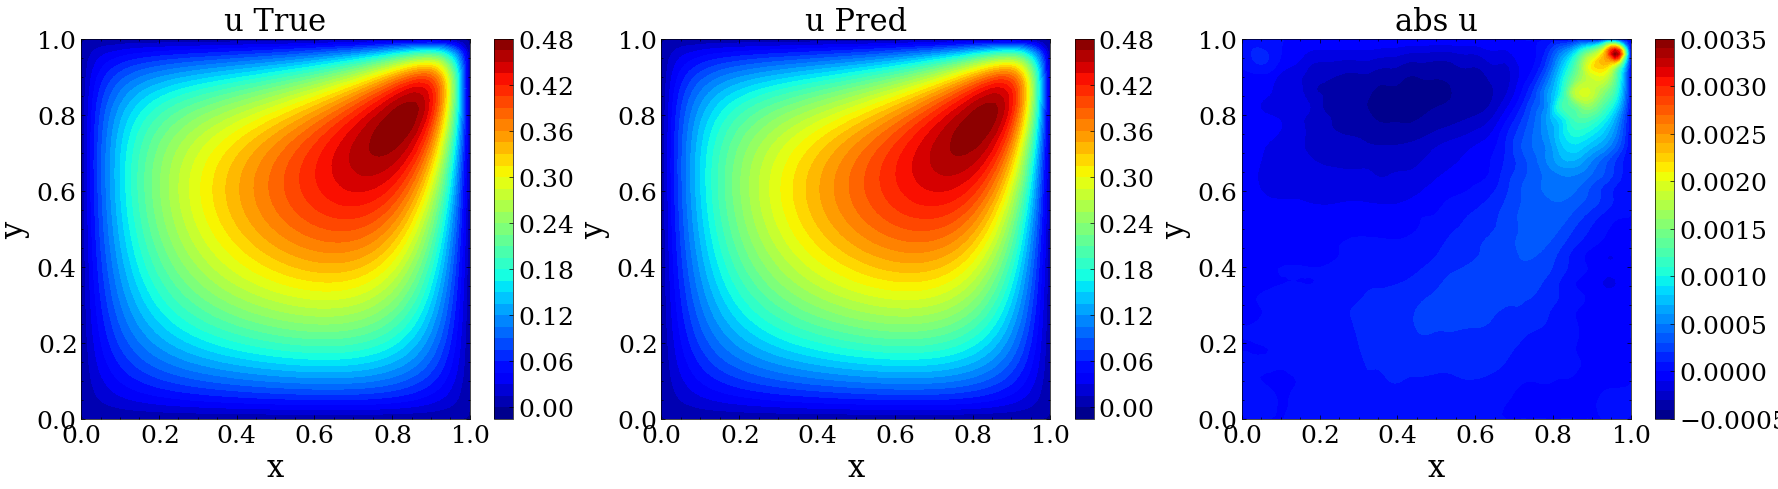

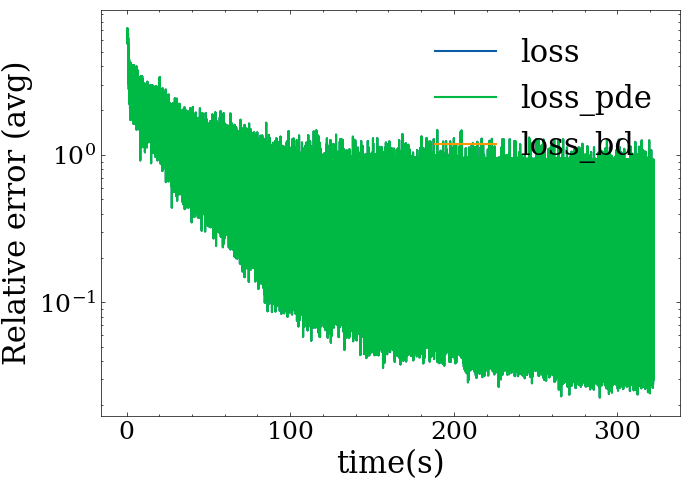

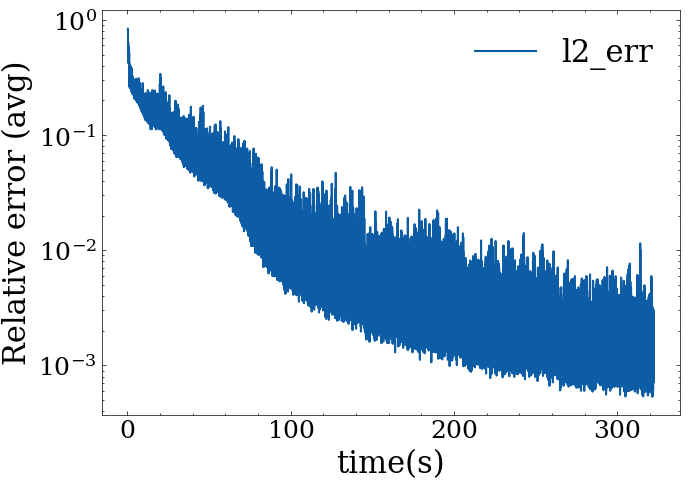

In [3]:
from Utils.PlotFigure import Plot
from Solvers.ParticleWNN import ParticleWNN
from Utils.Losses import * 
myerror = MyLoss().lp_rel
###############################
# load trained model
###############################
solver = ParticleWNN.Solver(device, dtype=dtype)
model_trained = solver.loadModel(path='saved_models/cts/', name='model_particlewnn_final')

###############################
# make prediction
###############################
x_var = Variable(x_test, requires_grad=True).to(device)
u_var = model_trained['u'](x_var)
u_var = mollifer()(u_var, x_var).detach().cpu()
#
print('The l2_err is', myerror(u_var, u_test))

###############################
# show the result
###############################
Plot.show_2d_list(x_test, [u_test, u_var, u_test-u_var], ['u True', 'u Pred', 'abs u'])
##### show the loss
loss_saved = solver.loadLoss(path='saved_models/cts/', name='loss_particlewnn')
Plot.show_error([loss_saved['time']]*3, 
                [loss_saved['loss'], loss_saved['loss_pde'], loss_saved['loss_bd']],
                ['loss', 'loss_pde', 'loss_bd'])
##### show the error
Plot.show_error([loss_saved['time']], [loss_saved['error']], ['l2_err'])